Loaded 240 images of class CHEETAH
Loaded 238 images of class OCELOT
Loaded 190 images of class CARACAL
Loaded 233 images of class LIONS
Loaded 242 images of class TIGER
Loaded 241 images of class PUMA
Loaded 1384 images total.
x shape: (1384, 224, 224, 3), y shape:(1384,)


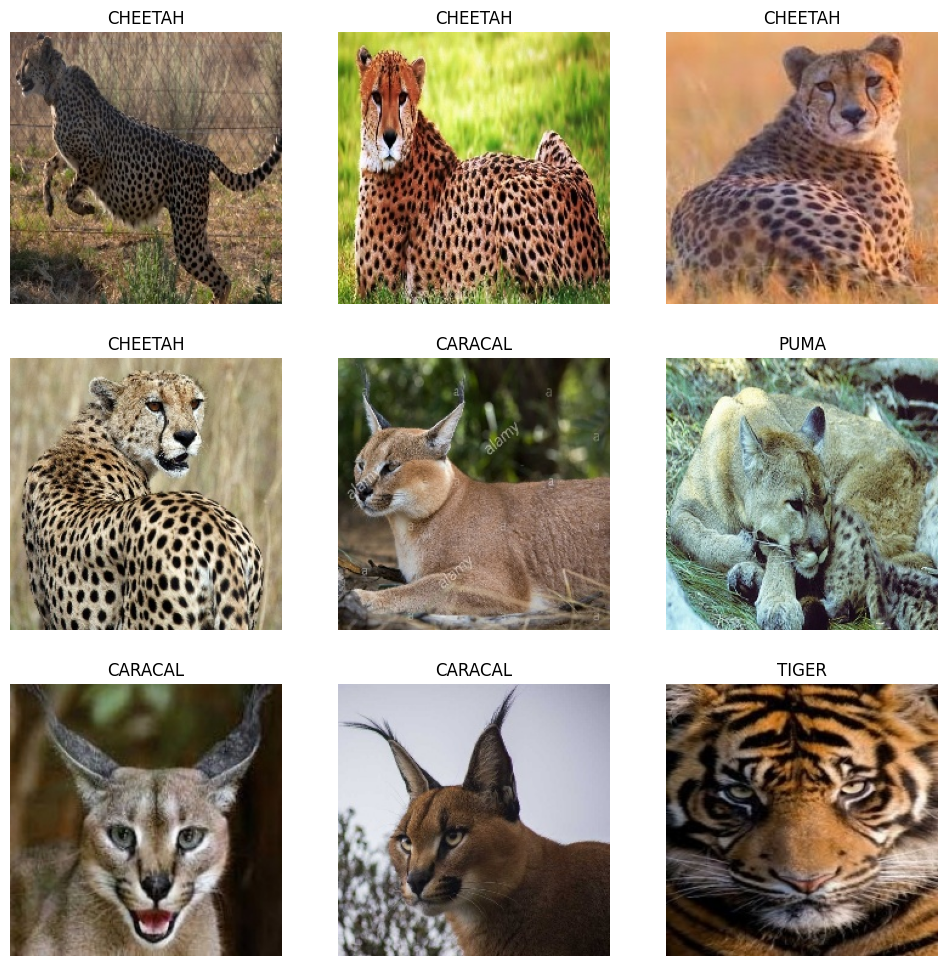

In [29]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

def load_imgs(path, folders):
    imgs = []
    labels = []
    n_imgs = 0
    for c in folders:
        # iterate over all the files in the folder
        for f in os.listdir(os.path.join(path, c).replace("/mnt/z", 'Z:\\')):
            if not f.endswith('.jpg'):
                continue
            # load the image (here you might want to resize the img to save memory)
            im = Image.open(os.path.join(path, c, f)).copy()
            imgs.append(im)
            labels.append(c)
        print('Loaded {} images of class {}'.format(len(imgs) - n_imgs, c))
        n_imgs = len(imgs)
    print('Loaded {} images total.'.format(n_imgs))
    return imgs, labels

def plot_sample(imgs, labels, nrows=4, ncols=4, resize=None):
    # create a grid of images
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    # take a random sample of images
    indices = np.random.choice(len(imgs), size=nrows*ncols, replace=False)
    for ax, idx in zip(axs.reshape(-1), indices):
        ax.axis('off')
        # sample an image
        ax.set_title(labels[idx])
        im = imgs[idx]
        if isinstance(im, np.ndarray):
            im = Image.fromarray(im)  
        if resize is not None:
            im = im.resize(resize)
        ax.imshow(im, cmap='gray')


# map class -> idx
label_to_idx = {
    'CHEETAH':0,
    'OCELOT': 1,
    'CARACAL':2,
    'LIONS': 3,
    'TIGER':4,
    'PUMA':5
}

idx_to_label = {
    0:'CHEETAH',
    1:'OCELOT',
    2:'CARACAL',
    3:'LIONS',
    4:'TIGER',
    5: 'PUMA'
}

def make_dataset(imgs, labels, label_map, img_size):
    x = []
    y = []
    n_classes = len(list(label_map.keys()))
    for im, l in zip(imgs, labels):
        # preprocess img
        x_i = im.resize(img_size)
        x_i = np.asarray(x_i)
        
        # encode label
        y_i = label_map[l]
        
        x.append(x_i)
        y.append(y_i)
    return np.array(x).astype('float32'), np.array(y)

def save_model(model, filepath):
    """
    Save PyTorch model to a file.

    Args:
        model: PyTorch model to be saved.
        filepath (str): Path to save the model.
    """
    torch.save(model.state_dict(), filepath)

def load_model(model_class, filepath, device='cpu'):
    """
    Load PyTorch model from a file.

    Args:
        model_class: Model class (e.g., ConvNet) to instantiate.
        filepath (str): Path from which to load the model.
        device (str): Device to move the model to (default is 'cpu').

    Returns:
        model: Loaded PyTorch model.
    """
    model = model_class() # change it to your own model class
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    return model

# Create new Dataset objects for the training and test datasets
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            if isinstance(x, np.ndarray):
                #print("s1", x.shape)
                #x = x.transpose(1, 2, 0)
                x = torch.tensor(x)
                #print("s2", x.shape, x.dtype)
                x = transforms.functional.to_pil_image(x)
            x = self.transform(x)
            x = x.numpy()
        return x, y

    def __len__(self):
        return len(self.data)


imgs, labels = load_imgs('/kaggle/input/dataset1/Dataset', ['CHEETAH' ,'OCELOT', 'CARACAL', 'LIONS', 'TIGER', 'PUMA']) #TODO CHANGE ME!!
X, y = make_dataset(imgs, labels, label_to_idx, (224,224))
print('x shape: {}, y shape:{}'.format(X.shape, y.shape))
plot_sample(imgs, labels, 3, 3, resize=(224, 224))

cuda
Epoch [1/101], Train Acc: 19.87, Val Acc: 18.41
Epoch [11/101], Train Acc: 47.88, Val Acc: 31.77
Epoch [21/101], Train Acc: 72.99, Val Acc: 38.99
Epoch [31/101], Train Acc: 85.37, Val Acc: 31.77
Epoch [41/101], Train Acc: 98.92, Val Acc: 34.66
Epoch [51/101], Train Acc: 77.51, Val Acc: 25.63
Epoch [61/101], Train Acc: 99.91, Val Acc: 33.21
Epoch [71/101], Train Acc: 100.00, Val Acc: 32.13
Epoch [81/101], Train Acc: 100.00, Val Acc: 31.41
Epoch [91/101], Train Acc: 100.00, Val Acc: 32.49
Epoch [101/101], Train Acc: 100.00, Val Acc: 31.77
Best accuracy: 38.99


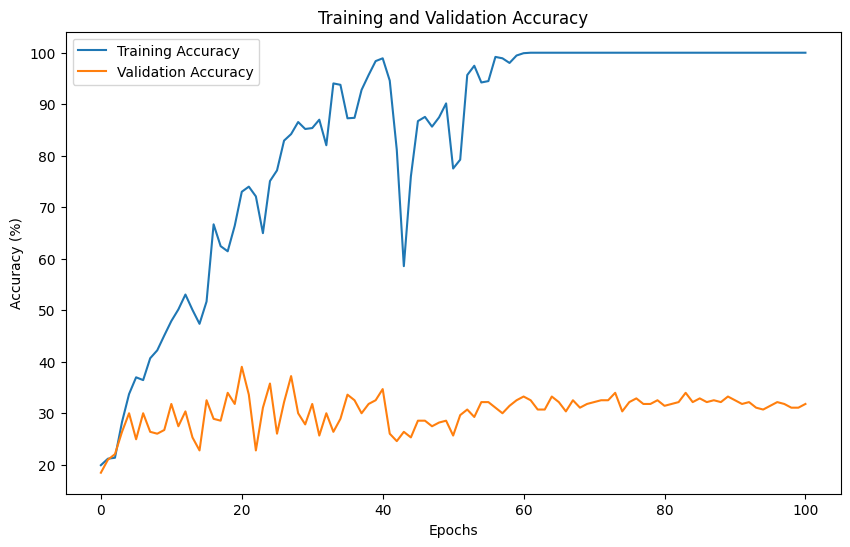

In [1]:
################### Task 1 ###################
import copy
from torch import nn
from torch.nn import functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# general context setting
CONFIGS = {
    'seed': 20020309, 
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
    'batch_size': 32,
    'epochs': 1 + 100, # 100 
    'learning_rate':  0.001,
    'optimizer': lambda model_params: torch.optim.Adam(model_params, lr=CONFIGS['learning_rate']),
    'criterion': nn.CrossEntropyLoss() # fits classification task with discrete values
}

np.random.seed(CONFIGS['seed'])
torch.manual_seed(CONFIGS['seed'])
print(CONFIGS['device'])


class FFNN(nn.Module):
    def __init__(self, _in_features, _num_classes):
        super(FFNN, self).__init__()
        # 3 layers
        self.fc1 = nn.Linear(_in_features, 128)  # input layer with 128 hidden units
        self.fc2 = nn.Linear(128, 64)  # hidden layer with 64 hidden units
        self.fc3 = nn.Linear(64, _num_classes)  # output layer with num_classes units

    def forward(self, _x):
        # pass through layers with GELU activation
        _x = F.gelu(self.fc1(_x))
        _x = F.gelu(self.fc2(_x))
        _x = self.fc3(_x) # no activation for the output layer, output raw logits
        return _x


def get_input(_f_features=None, _permute=False):
    """_features is a function"""
    def safe_copy(*args):
        return map(lambda el: el.copy(), *args)
    
    _x, _y = safe_copy(make_dataset(imgs, labels, label_to_idx, (224,224))) # from init given cell
    _x = _x / 255.0 # normalizing images
    
    _feats = None
    if _f_features is not None:
        _feats = _f_features(_x)
        
    if _permute:
        pass
        # print('Permuting dimensions', _x.shape)
        _x = _x.transpose(0, 3, 1, 2) # rearrange dimensions for cnn
        # print('Permuted dimensions', _x.shape)
    else: 
        _x = _x.reshape(_x.shape[0], -1) # 1D vector image flattened
        
    _encoder = OneHotEncoder(sparse_output=False, categories="auto")
    _y = _encoder.fit_transform(_y.reshape(-1, 1))
    return _x, _y, _feats 


def get_loads(_x, _y, _ratio, _transform=None, _batch_size=CONFIGS["batch_size"]):
    _data = [(_x[i], _y[i]) for i in range(len(_x))]
    _train_data, _test_data = train_test_split(
        _data, train_size=_ratio, random_state=CONFIGS['seed']
    )
    # prepare data for training DataLoader
    _train_dataset = Dataset(_train_data, transform=_transform) # transform makes sense only on training data
    _test_dataset = Dataset(_test_data)
    # create dataLoader for both training and test datasets
    _train_loader = DataLoader(_train_dataset, batch_size=_batch_size, shuffle=True)
    _test_loader = DataLoader(_test_dataset, batch_size=_batch_size, shuffle=True)
    return _train_loader, _test_loader


def calculate_accuracy(_y_true, _y_pred):
    _predicted_classes = torch.argmax(_y_pred, dim=1)
    _true_classes = torch.argmax(_y_true, dim=1)
    _correct = (_predicted_classes == _true_classes).sum().item()
    return _correct


def load_to_device(*args):
    return map(lambda el: el.to(CONFIGS["device"]), args)


# plot training and test accuracies
def plot_train_test(_train_acc, _val_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(_train_acc, label='Training Accuracy')
    plt.plot(_val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()
    
    
def train(_model, _criterion, _optimizer, _loaders, _epochs=CONFIGS["epochs"]):
    _train_loader, _test_loader = _loaders
    # train the model and get accuracies
    _train_acc = []
    _test_acc = []
    _best_test_accuracy = 0
    _best_model = None
    for _epoch in range(_epochs):
        _model.train()
        _running_loss = 0
        _correct = 0
        _total = 0
        for _inputs, _labels in _train_loader:
            _inputs, _labels = load_to_device(_inputs, _labels)
            _optimizer.zero_grad()
            _outputs = _model(_inputs)
            _loss = _criterion(_outputs, _labels.float())
            _loss.backward()
            _optimizer.step()
            _running_loss += _loss.item()
            # compute accuracy
            _correct += calculate_accuracy(_labels, _outputs)
            _total += _labels.size(0)
            
        _train_accuracy = 100 * _correct / _total
        _train_acc.append(_train_accuracy)

        # validation
        _model.eval()
        _test_correct = 0
        _test_total = 0
        with torch.no_grad():
            for _inputs, _labels in _test_loader:
                _inputs, _labels = load_to_device(_inputs, _labels)
                _outputs = _model(_inputs)
                _test_correct += calculate_accuracy(_labels, _outputs)
                _test_total += _labels.size(0)
                
        _test_accuracy = 100 * _test_correct / _test_total
        _test_acc.append(_test_accuracy)
        if _test_accuracy > _best_test_accuracy:
            _best_test_accuracy = _test_accuracy
            # Save best model
            _best_model = copy.deepcopy(_model)

        if _epoch % 10 == 0:
            print(f"Epoch [{_epoch+1}/{CONFIGS['epochs']}]", 
                  f"Train Acc: {_train_accuracy:.2f}",
                  f"Val Acc: {_test_accuracy:.2f}",
                  sep=", ")
            
    print(f"Best accuracy: {_best_test_accuracy:.2f}")
    return _train_acc, _test_acc, _best_model


x, y, _ = get_input()
train_loader, test_loader = get_loads(x, y, 0.8)
model = FFNN(x.shape[1], len(label_to_idx)).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model.parameters())
train_acc, test_acc, best_model = train(model, CONFIGS["criterion"], optimizer, (train_loader, test_loader))
save_model(best_model, 'best_ffnn.pth')
test_acc_t1 = test_acc.copy() # used later on for statistical comparison
plot_train_test(train_acc, test_acc)

Epoch [1/101], Train Acc: 17.89, Val Acc: 24.55
Epoch [11/101], Train Acc: 31.35, Val Acc: 25.27
Epoch [21/101], Train Acc: 31.44, Val Acc: 28.16
Epoch [31/101], Train Acc: 31.44, Val Acc: 29.96
Epoch [41/101], Train Acc: 31.98, Val Acc: 27.44
Epoch [51/101], Train Acc: 32.16, Val Acc: 32.13
Epoch [61/101], Train Acc: 32.43, Val Acc: 32.13
Epoch [71/101], Train Acc: 32.88, Val Acc: 32.85
Epoch [81/101], Train Acc: 34.33, Val Acc: 29.96
Epoch [91/101], Train Acc: 34.15, Val Acc: 31.05
Epoch [101/101], Train Acc: 34.15, Val Acc: 33.94
Best accuracy: 34.30


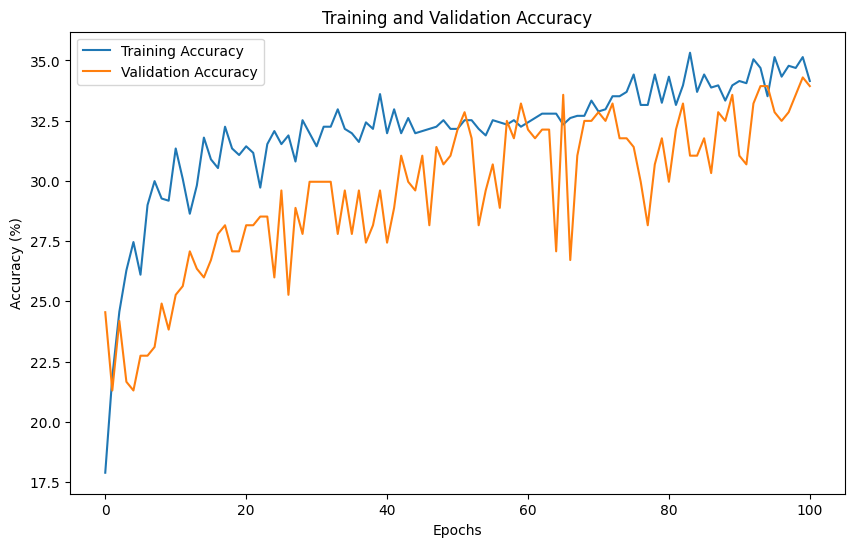

In [31]:
################### Task 1 BONUS ###################
def get_features(_imgs):
    _feats = []
    _r, _g, _b = 0, 1, 2
    get_mean_var = lambda img, idx : (np.mean(img[:,:,idx]), np.var(img[:,:,idx]))
    for _img in _imgs:
        _r_mean_var = get_mean_var(_img, _r)
        _g_mean_var = get_mean_var(_img, _g)
        _b_mean_var = get_mean_var(_img, _b)
        _feats.append([*_r_mean_var, *_g_mean_var, *_b_mean_var])
    return np.array(_feats)


_, y, feats = get_input(get_features)
train_loader, test_loader = get_loads(feats, y, 0.8)
model = FFNN(feats.shape[1], len(label_to_idx)).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model.parameters())
train_acc, test_acc, best_model = train(model, CONFIGS["criterion"], optimizer, (train_loader, test_loader))
save_model(best_model, 'best_ffnn_aug.pth')
test_aug_acc_t1 = test_acc.copy() # used later on for statistical comparison
plot_train_test(train_acc, test_acc)

Epoch [1/101], Train Acc: 19.69, Val Acc: 18.77
Epoch [11/101], Train Acc: 98.55, Val Acc: 65.34
Epoch [21/101], Train Acc: 100.00, Val Acc: 66.79
Epoch [31/101], Train Acc: 100.00, Val Acc: 66.79
Epoch [41/101], Train Acc: 100.00, Val Acc: 65.70
Epoch [51/101], Train Acc: 100.00, Val Acc: 67.15
Epoch [61/101], Train Acc: 100.00, Val Acc: 66.43
Epoch [71/101], Train Acc: 100.00, Val Acc: 67.87
Epoch [81/101], Train Acc: 100.00, Val Acc: 67.87
Epoch [91/101], Train Acc: 100.00, Val Acc: 67.87
Epoch [101/101], Train Acc: 100.00, Val Acc: 67.87
Best accuracy: 68.23


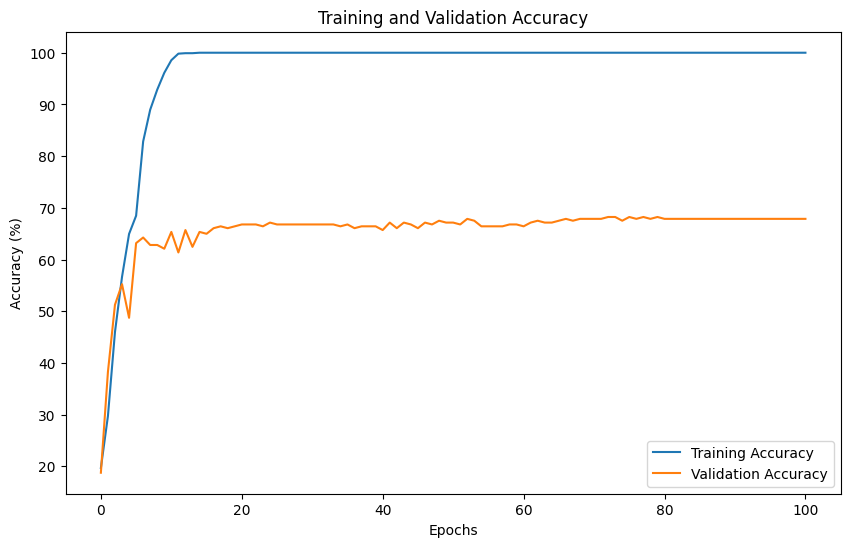

T-statistic: -69.2212970163193, P-value: 2.7086778610384287e-86
There is a statistically significant difference between the performances of T1 and T2.
Epoch [1/101], Train Acc: 18.07, Val Acc: 17.33
Epoch [11/101], Train Acc: 61.70, Val Acc: 53.43
Epoch [21/101], Train Acc: 80.76, Val Acc: 72.20
Epoch [31/101], Train Acc: 89.34, Val Acc: 74.73
Epoch [41/101], Train Acc: 94.04, Val Acc: 82.31
Epoch [51/101], Train Acc: 95.66, Val Acc: 83.39
Epoch [61/101], Train Acc: 95.75, Val Acc: 79.42
Epoch [71/101], Train Acc: 96.66, Val Acc: 82.31
Epoch [81/101], Train Acc: 96.84, Val Acc: 83.75
Epoch [91/101], Train Acc: 97.38, Val Acc: 81.95
Epoch [101/101], Train Acc: 97.56, Val Acc: 79.06
Best accuracy: 86.28


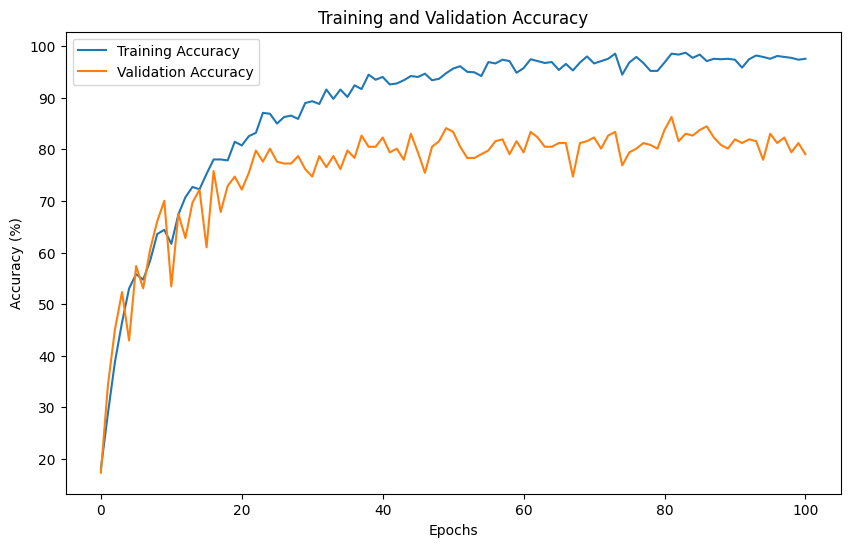

T-statistic: -16.509919337870027, P-value: 2.548834276946093e-30
There is a statistically significant difference between the performances of T2 and T2 AUGMENTED.


In [3]:
################### Task 2 ###################
from scipy.stats import ttest_rel
from torchvision import transforms
from scipy.stats import ttest_rel # build a function for statistical comparison

class RecipeCNN(nn.Module):
    def __init__(self, _num_classes):
        super(RecipeCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, _num_classes)

    def forward(self, _x):
        _x = self.pool1(F.relu(self.conv1(_x)))
        _x = self.pool2(F.relu(self.conv2(_x)))
        _x = self.pool3(F.relu(self.conv3(_x)))
        _x = _x.view(_x.size(0), -1) 
        _x = F.relu(self.fc1(_x))
        _x = F.relu(self.fc2(_x))
        _x = F.relu(self.fc3(_x))
        _x = self.fc4(_x)
        return _x

# """
x, y, _ = get_input(_permute=True) # permute dimensions
train_loader, test_loader = get_loads(x, y, 0.8)
model = RecipeCNN(len(label_to_idx)).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model.parameters())
train_acc, test_acc, best_model = train(model, CONFIGS["criterion"], optimizer, (train_loader, test_loader))
save_model(best_model, 'best_cnn.pth')
test_acc_t2 = test_acc.copy() # used later on for statistical comparison
plot_train_test(train_acc, test_acc)

# 5. STATISTICAL COMPARISON
t_stat, p_value = ttest_rel(test_acc_t1[:CONFIGS["epochs"]], test_acc_t2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# interpretation of the result
if p_value < 0.05:
    print("There is a statistically significant difference between the performances of T1 and T2.")
else:
    print("There is no statistically significant difference between the performances of T1 and T2.")

# """

#--------------------------------------------------------
# 6. apply image manipulation and augmentation techniques
#--------------------------------------------------------
# defining some transformations
augmentation_transforms = transforms.Compose([
    # transforms.Resize((224, 224)),  # ensure images have correct input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


x, y, feats = get_input(_permute=True) # permute dimensions
train_loader, test_loader = get_loads(x, y, 0.8, _transform=augmentation_transforms)
model = RecipeCNN(len(label_to_idx)).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model.parameters())
train_acc, test_acc, best_model = train(model, CONFIGS["criterion"], optimizer, (train_loader, test_loader))
save_model(best_model, 'best_cnn_aug.pth')
test_aug_acc_t2 = test_acc.copy() # used later on for statistical comparison
plot_train_test(train_acc, test_acc)

# STATISTICAL COMPARISON
t_stat, p_value = ttest_rel(test_acc_t2, test_aug_acc_t2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# interpretation of the result
if p_value < 0.05:
    print("There is a statistically significant difference between the performances of T2 and T2 AUGMENTED.")
else:
    print("There is no statistically significant difference between the performances of T2 and T2 AUGMENTED.")

In [33]:
################### Task 2 BONUS ###################
from sklearn.model_selection import ParameterGrid

# define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'epochs': [CONFIGS["epochs"]]
}

# function to perform training and validation
def train_and_evaluate_model(_params):
    _x, _y, _ = get_input(_permute=True) # permute dimensions
    _train_loader, _test_loader = get_loads(_x, _y, 0.8)
    _model = RecipeCNN(len(label_to_idx)).to(CONFIGS["device"])
    _optimizer = torch.optim.Adam(_model.parameters(), lr=_params['learning_rate'])
    _train_acc, _test_acc, _best_model = train(
        _model, CONFIGS["criterion"], _optimizer, (_train_loader, _test_loader), _epochs=_params['epochs']
    )
    return max(_test_acc), _best_model
    

# grid search execution
best_overall_accuracy = 0
best_overall_params = None
best_model_weights = None

for grid_params in ParameterGrid(param_grid):
    print(f"Testing with parameters: {grid_params}")
    accuracy, model = train_and_evaluate_model(grid_params)
    print(f"Accuracy: {accuracy}")

    if accuracy > best_overall_accuracy:
        best_overall_accuracy = accuracy
        best_overall_params = grid_params
        best_model_weights = model.state_dict()

# output the best parameters and set the best model
print(f"Best Parameters: {best_overall_params}")
model.load_state_dict(best_model_weights)
torch.save(model.state_dict(), 'best_grid.pth')

Testing with parameters: {'batch_size': 32, 'epochs': 101, 'learning_rate': 0.001}
Epoch [1/101], Train Acc: 21.05, Val Acc: 27.44
Epoch [11/101], Train Acc: 99.01, Val Acc: 53.07
Epoch [21/101], Train Acc: 100.00, Val Acc: 66.43
Epoch [31/101], Train Acc: 100.00, Val Acc: 66.06
Epoch [41/101], Train Acc: 100.00, Val Acc: 65.34
Epoch [51/101], Train Acc: 100.00, Val Acc: 65.34
Epoch [61/101], Train Acc: 100.00, Val Acc: 65.34
Epoch [71/101], Train Acc: 100.00, Val Acc: 66.06
Epoch [81/101], Train Acc: 100.00, Val Acc: 66.43
Epoch [91/101], Train Acc: 100.00, Val Acc: 66.79
Epoch [101/101], Train Acc: 100.00, Val Acc: 66.06
Best accuracy: 67.15
Accuracy: 67.14801444043322
Testing with parameters: {'batch_size': 32, 'epochs': 101, 'learning_rate': 0.0001}
Epoch [1/101], Train Acc: 21.32, Val Acc: 24.55
Epoch [11/101], Train Acc: 69.83, Val Acc: 59.57
Epoch [21/101], Train Acc: 93.22, Val Acc: 62.09
Epoch [31/101], Train Acc: 100.00, Val Acc: 61.01
Epoch [41/101], Train Acc: 100.00, Val A

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

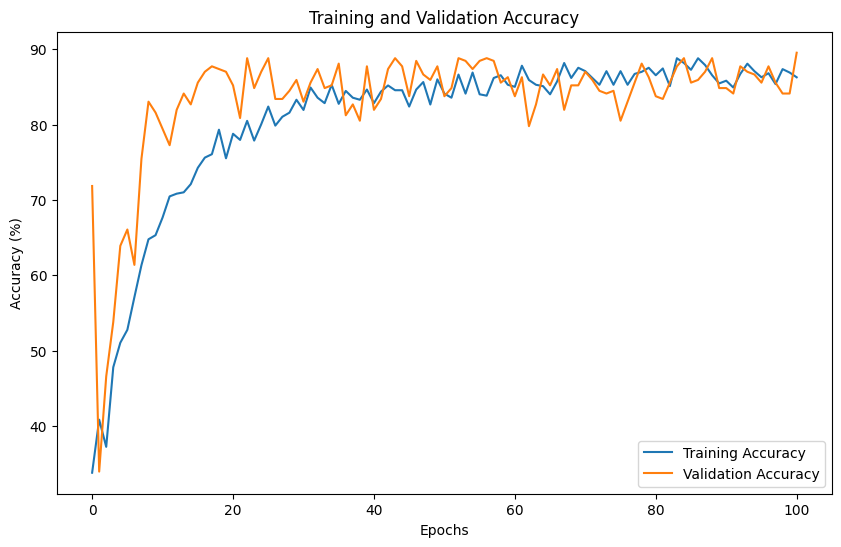

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

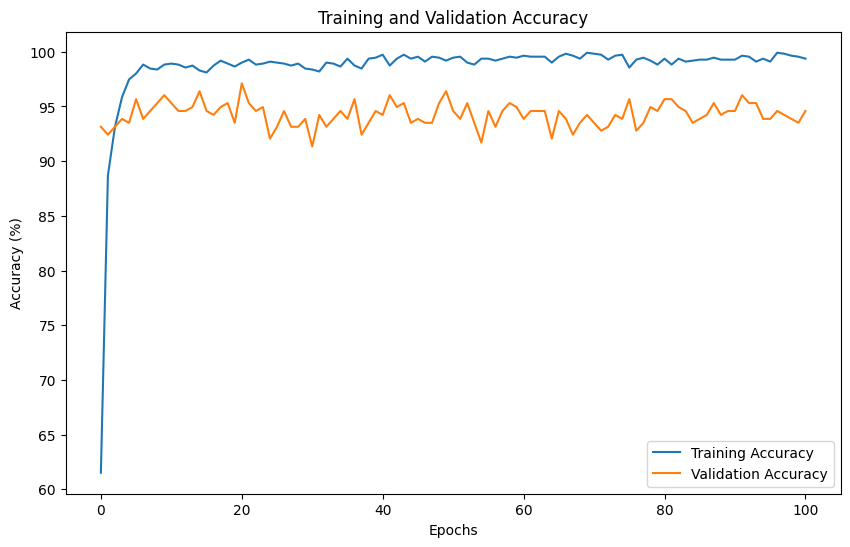

T-statistic: -13.367949381866463, P-value: 5.470139290111757e-24
There is a statistically significant difference between the performances of cut1 and cut2 AUGMENTED.


In [34]:
################### Task 3 ###################
import torch.nn as nn
import torchvision.models as models

class CuttedModifiedVGG19(nn.Module):
    def __init__(self, num_classes, cut_point):
        super(CuttedModifiedVGG19, self).__init__()
        # Load the pre-trained VGG19 model
        vgg19 = models.vgg19(pretrained=True)
        # you can see the VGG19 detailed architecture
        #print(vgg19)
        # Extract the feature extractor part of VGG19 (all layers except the classifier)
        # TODO specify your cut layer
        self.cut_value = cut_point
        self.features =  nn.Sequential(*list(vgg19.features.children())[:self.cut_value]) #vgg19.features
        
        # check your new model based on the cut
        print(self.features)
        
       
        for param in self.features.parameters():
            param.requires_grad = False
            
        # TODO Initialize your layers
        # dummy input of a 224x224 with rgb (3 channels) to get flatten dimension
        dummy_input = torch.zeros(1, 3, 224, 224)
        #print("s1", dummy_input.shape)
        _flat_dimension = None
        with torch.no_grad():
            _output = self.features(dummy_input)
            _flat_dimension = _output.view(_output.size(0), -1).size(1)

        # additional classifier layers similar to VGG's Block 6
        self.classifiers = nn.Sequential(
            nn.Linear(_flat_dimension, 256),  # dimension depending on input size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # Pass input through VGG19 feature extractor
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten features
        x = self.classifiers(x)  # pass through classifier
        return x



# TODO Training LOOP
cuts = {
    1: 25,
    2: None,
}

x, y, _ = get_input(_permute=True) # permute dimensions
train_loader, test_loader = get_loads(x, y, 0.8)

# """
model_cut1 = CuttedModifiedVGG19(num_classes=len(label_to_idx), cut_point=cuts[1]).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model_cut1.classifiers.parameters()) 
train_acc, test_acc, best_model = train(model_cut1, CONFIGS["criterion"], optimizer, (train_loader, test_loader))
save_model(best_model, 'best_cnn_cut1.pth')
test_acc_t3_cut1 = test_acc.copy() # used later on for statistical comparison
plot_train_test(train_acc, test_acc)
# """

model_cut2 = CuttedModifiedVGG19(num_classes=len(label_to_idx), cut_point=cuts[2]).to(CONFIGS["device"])
optimizer = CONFIGS["optimizer"](model_cut2.classifiers.parameters()) # Only optimize classifier parameters
train_acc, test_acc, best_model = train(model_cut2, CONFIGS["criterion"], optimizer, (train_loader, test_loader))
save_model(best_model, 'best_cnn_cut2.pth')
test_acc_t3_cut2 = test_acc.copy() # used later on for statistical comparison
plot_train_test(train_acc, test_acc)

# STATISTICAL COMPARISON
t_stat, p_value = ttest_rel(test_acc_t3_cut1, test_acc_t3_cut2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation of the result
if p_value < 0.05:
    print("There is a statistically significant difference between the performances of cut1 and cut2 AUGMENTED.")
else:
    print("There is no statistically significant difference between the performances of cut1 and cut2 AUGMENTED.")

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Epoch [1/101], Train Acc: 19.24, Val Acc: 15.88
Epoch [11/101], Train Acc: 15.36, Val Acc: 14.08
Epoch [21/101], Train Acc: 18.07, Val Acc: 14.44
Epoch [31/101], Train Acc: 16.53, Val Acc: 14.44
Epoch [41/101], Train Acc: 16.53, Val Acc: 14.44
Epoch [51/101], Train Acc: 17.52, Val Acc: 14.44
Epoch [61/101], Train Acc: 18.79, Val Acc: 14.44
Epoch [71/101], Train Acc: 16.80, Val Acc: 14.44
Epoch [81/101], Train Acc: 16.80, Val Acc: 14.44
Epoch [91/101], Train Acc: 17.43, Val Acc: 14.44
Epoch [101/101], Train Acc: 18.79, Val Acc: 14.44
Best accuracy: 15.88
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3,

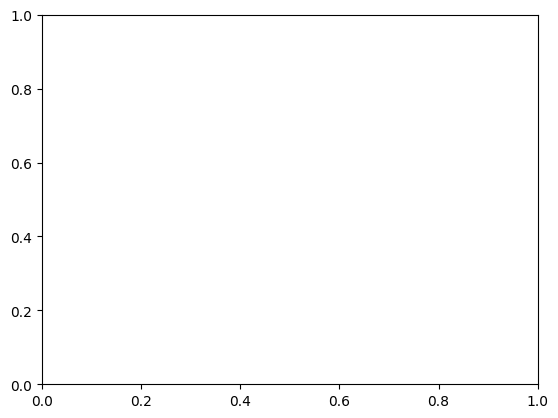

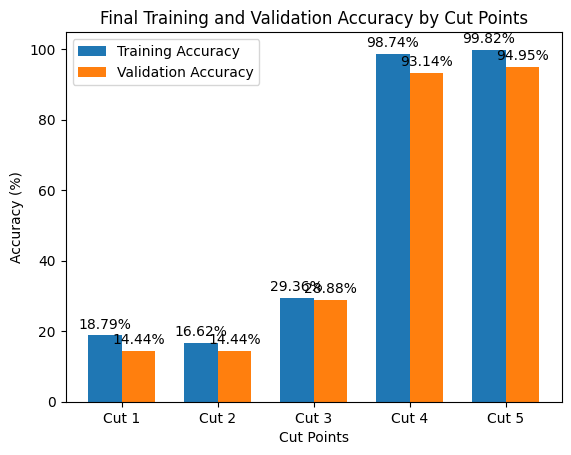

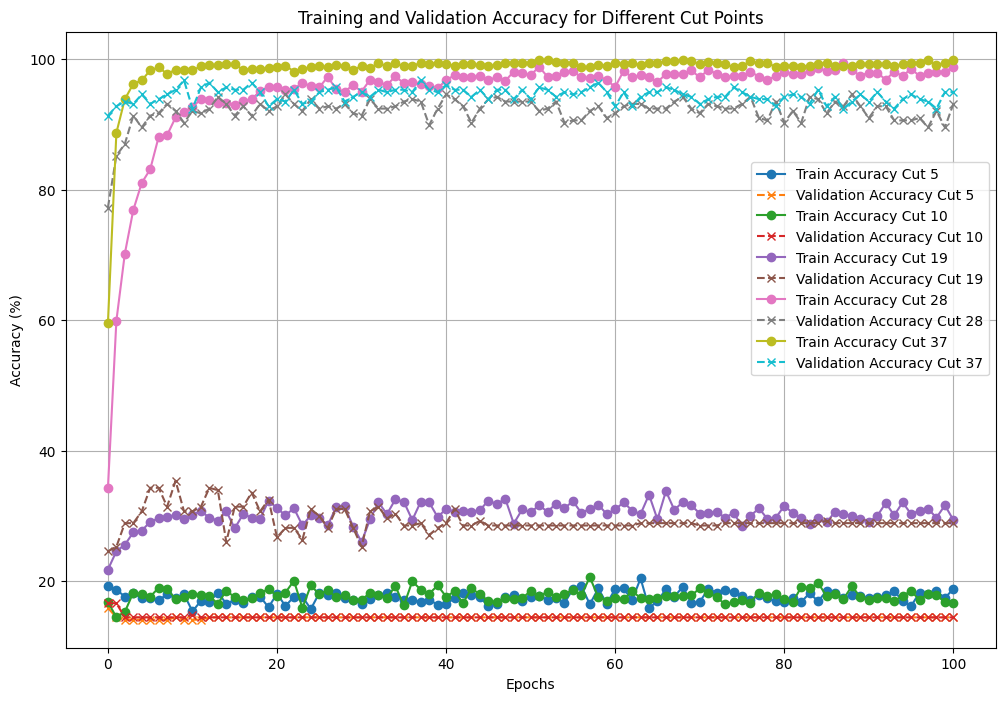

In [35]:
################### Task 3 Bonus ###################
bonus_cuts = {
    1: 5,   # end of first block
    2: 10,  # end of second block
    3: 19,  # end of third block
    4: 28,  # end of fourth block
    5: 37   # end of fifth block
}

test_acc_bonus = []

for cut_point in bonus_cuts.values():
    model_cut = CuttedModifiedVGG19(num_classes=len(label_to_idx), cut_point=cut_point).to(CONFIGS["device"])
    optimizer = CONFIGS["optimizer"](model_cut.classifiers.parameters())  
    train_acc, test_acc, best_model = train(model_cut, CONFIGS["criterion"], optimizer, (train_loader, test_loader))
    test_acc_bonus.append((train_acc, test_acc))
    
train_accuracies, test_accuracies = zip(*test_acc_bonus)
fig, ax = plt.subplots()

# extract accuracies of the last epoch
final_train_accuracies = [acc[-1] for acc in train_accuracies]
final_test_accuracies = [acc[-1] for acc in test_accuracies]

bar_width = 0.35

fig, ax = plt.subplots()
x_ticks = np.array(list(bonus_cuts.keys()))
bars1 = ax.bar(x_ticks, final_train_accuracies, bar_width, label='Training Accuracy')
bars2 = ax.bar(x_ticks + bar_width, final_test_accuracies, bar_width, label='Validation Accuracy')

# plotting histogram
ax.set_xlabel('Cut Points')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Final Training and Validation Accuracy by Cut Points')
ax.set_xticks(x_ticks + bar_width / 2)
ax.set_xticklabels([f'Cut {i}' for i in x_ticks])
ax.legend()

# add labels on the top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)
plt.show()


train_accuracies = np.array(train_accuracies)
test_accuracies = np.array(test_accuracies)

# plotting accuracy lines
plt.figure(figsize=(12, 8))

for i, cut in enumerate(bonus_cuts.values()):
    plt.plot(train_accuracies[i], label=f'Train Accuracy Cut {cut}', marker='o')
    plt.plot(test_accuracies[i], label=f'Validation Accuracy Cut {cut}', linestyle='--', marker='x')

# adding labels, title and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy for Different Cut Points')
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.3, 0.5, 0.5))
plt.grid(True)
plt.show()